In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack,csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
train_df = pd.read_csv('./data/all/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('./data/all/test_sessions.csv',
                      index_col='session_id')

In [4]:
# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
y_train = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]

In [6]:
full_df.shape

(336358, 20)

In [7]:
sites = ['site%s' % i for i in range(1, 11)]
full_sites = full_df[sites]

sites_flatten = full_sites.values.flatten()

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [8]:
# %%time
# sites = ['site%s' % i for i in range(1, 11)]

# full_df[sites].fillna(0).astype('int').to_csv('./data/all/full_sessions_text.txt', 
#                                                sep=' ', index=None, header=None)

# cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)

# with open('./data/all/full_sessions_text.txt') as inp_train_file:
#     full_sites_sparse = cv.fit_transform(inp_train_file)

In [9]:
full_sites_sparse.shape

(336358, 48371)

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

Tf_trn = TfidfTransformer()

full_sites_sparse = Tf_trn.fit_transform(full_sites_sparse).tocsr()

full_sites_sparse.shape

(336358, 48371)

In [11]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [12]:
def get_auc_roc_cv(X,y,best_C ={'C':1},seed=17):
    lr = LogisticRegression(C=best_C['C'], random_state=seed, solver='liblinear')
    time_split = TimeSeriesSplit(n_splits=10)    
    scores =cross_val_score(lr,X,y,cv=time_split,scoring='roc_auc')
    return (scores,scores.mean(),scores.std())

In [13]:
def cross_val_C_calc(X,y, c_values=np.logspace(-2, 2, 10),seed=17):
    
    logit = LogisticRegression(C=1, random_state=seed)
    time_split = TimeSeriesSplit(n_splits=10)
    
    logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                      scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
    logit_grid_searcher.fit(X, y)

    return (logit_grid_searcher.best_score_, logit_grid_searcher.best_params_, logit_grid_searcher)

In [14]:
X_train = full_sites_sparse.tocsr()[:idx_split,:]
X_test = full_sites_sparse.tocsr()[idx_split:,:]

In [15]:
# cross_val_C_calc(X_train,y_train)

In [21]:
print(get_auc_lr_valid(X_train,y_train))

0.9244205565941578


In [23]:
print(get_auc_roc_cv(X_train,y_train)[1])

0.8621217486174444


In [16]:
def add_time_features(df, X_sparse):
    
    full_new_feature = pd.DataFrame(index=df.index)
    hour = df['time1'].apply(lambda ts: ts.hour)
    full_new_feature['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
    full_new_feature["day"] = ((hour >= 12) & (hour <= 18)).astype('int')
    full_new_feature["evening"] = ((hour >= 19) & (hour <= 23)).astype('int')
    full_new_feature["night"] = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, full_new_feature.values])
    return X

In [17]:
%%time
full_sites_sparse = add_time_features(full_df.fillna(0), full_sites_sparse)

Wall time: 2min 45s


In [18]:
X_train = full_sites_sparse.tocsr()[:idx_split,:]
X_test = full_sites_sparse.tocsr()[idx_split:,:]

In [27]:
get_auc_lr_valid(X_train,y_train)

0.9526003398402968

In [29]:
get_auc_roc_cv(X_train,y_train)[1]

0.919781477617683

--------------------------------------------
--------------------------------------------

### Start month and hour

In [35]:
full_new_feature = pd.DataFrame(index=full_df.index)
full_new_feature['start_hour'] = full_df.time1.dt.hour
full_new_feature['start_month'] = full_df['time1'].apply(lambda ts:100 * ts.year + ts.month).astype('float64')

In [35]:
tmp_scaled_full = StandardScaler().fit_transform(full_new_feature[['start_month']])

In [36]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],tmp_scaled_full[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],tmp_scaled_full[idx_split:,:]]).tocsr()

In [37]:
get_auc_lr_valid(X_train,y_train)

0.9529750216174177

In [38]:
get_auc_roc_cv(X_train,y_train)[1]

0.9239273309729109

## Above is good feature

### time difference between sessions

In [36]:
timesdf = full_df[times].fillna(method='ffill',axis=1)
# timesdf.head()

In [37]:
timedff = timesdf.diff(axis=1,periods=1)
timedff.head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,NaT,00:00:00,00:00:00,00:00:00,00:00:00,0 days,00:00:00,00:00:00,00:00:00,00:00:00
54843,NaT,00:00:00,00:29:44,00:00:02,00:00:00,0 days,00:00:00,00:00:00,00:00:00,00:00:00
77292,NaT,00:00:01,00:00:01,00:00:00,00:00:01,0 days,00:00:00,00:00:00,00:00:01,00:00:00
114021,NaT,00:00:00,00:00:01,00:00:00,00:00:00,0 days,00:00:01,00:00:00,00:00:00,00:00:01
146670,NaT,00:00:00,00:00:00,00:00:01,00:00:00,0 days,00:00:00,00:00:01,00:00:00,00:00:00


In [38]:
timedff = timedff.apply(lambda x: np.log1p(x.dt.seconds.astype(float))).iloc[:,1:]

C:\Users\h213139\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [39]:
timedff.head()

,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,
21669,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
54843,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
77292,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000
114021,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147
146670,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000


In [196]:
tmp_scaled_time = StandardScaler().fit_transform(timedff)

In [197]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],tmp_scaled_time[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],tmp_scaled_time[idx_split:,:]]).tocsr()

In [198]:
get_auc_roc_cv(X_train,y_train)[1]

0.9177752179593778

In [199]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],timedff.values[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],timedff.values[idx_split:,:]]).tocsr()

In [200]:
get_auc_roc_cv(X_train,y_train)[1]

0.9175255469484112

### Max time difference

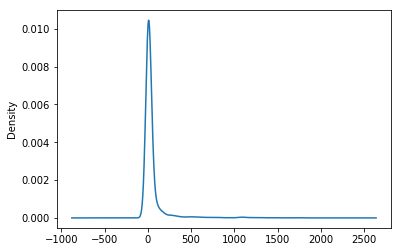

In [90]:
timedff.loc[train_df.target==1,].max(axis=1).sort_values(ascending=False).plot.density();

In [80]:
timedff.loc[train_df.target==0,].max(axis=1).sort_values(ascending=False).head(10)

session_id
162899    1800
248182    1800
222264    1800
88187     1800
76162     1800
174514    1800
32355     1800
243589    1800
40062     1800
24392     1800
dtype: int64

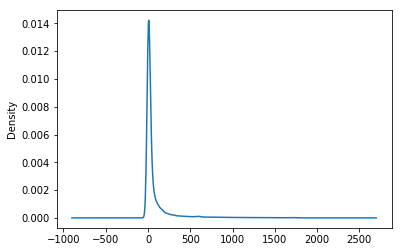

In [92]:
timedff.loc[train_df.target==0,].max(axis=1).sort_values(ascending=False).plot.density();

### Adding first site and last site

In [98]:
# def func1(x):
#     if x.first_valid_index() is None:
#         return None
#     else:
#         return x[x.first_valid_index()]
    
# def func2(x):
#     if x.last_valid_index() is None:
#         return None
#     else:
#         return x[x.last_valid_index()]
    
# last_site =full_df[sites].apply(func2, axis=1)
# first_site =full_df[sites].apply(func1, axis=1)

# first_site.to_pickle('./data/all/first_site.pkl')
# last_site.to_pickle('./data/all/last_site.pkl')

In [27]:
first_site = pd.read_pickle('./data/all/first_site.pkl')
last_site = pd.read_pickle('./data/all/last_site.pkl')

In [108]:
first_site.head()

session_id
21669      56.0
54843      56.0
77292     946.0
114021    945.0
146670    947.0
dtype: float64

In [109]:
last_site.head()

session_id
21669      55.0
54843      55.0
77292     946.0
114021    946.0
146670    947.0
dtype: float64

In [100]:
first_site.value_counts().head()

21.0     17910
23.0     11737
782.0    10910
29.0      7445
22.0      7054
dtype: int64

In [101]:
last_site.value_counts().head()

21.0     16786
782.0    11003
23.0     10949
22.0      7692
29.0      7419
dtype: int64

In [40]:
firstTop10Alice = first_site.loc[train_df.target==1,].value_counts(normalize=True).head(10).index.tolist()

In [41]:
firstTop10Rest = first_site.loc[train_df.target==0,].value_counts(normalize=True).head(10).index.tolist()

In [42]:
lastTop10Alice =last_site.loc[train_df.target==1,].value_counts(normalize=True).head(10).index.tolist()

In [43]:
lastTop10Rest=last_site.loc[train_df.target==0,].value_counts(normalize=True).head(10).index.tolist()

In [44]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [111]:
first_site = LabelEncoder().fit_transform(first_site)
last_site = LabelEncoder().fit_transform(last_site)

In [112]:
first_site_normalize = StandardScaler().fit_transform(first_site.reshape(-1, 1))
last_site_normalize= StandardScaler().fit_transform(last_site.reshape(-1, 1))

C:\Users\h213139\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [113]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],first_site_normalize[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],first_site_normalize[idx_split:,:]]).tocsr()

In [114]:
get_auc_lr_valid(X_train,y_train)

0.9533388343018903

In [115]:
get_auc_roc_cv(X_train,y_train)[1]

0.9184914104664929

In [118]:
first_site.corr(last_site)

0.3995916326858061

--------------------------------------------
--------------------------------------------

### Encoding top 10sites

In [45]:
firstTop10onlyAlice = [x for x in firstTop10Alice if x not in firstTop10Rest]

In [46]:
firstTop10Alice,firstTop10Rest

([80.0, 77.0, 76.0, 21.0, 29.0, 23.0, 22.0, 81.0, 879.0, 82.0],
 [21.0, 23.0, 782.0, 29.0, 22.0, 167.0, 778.0, 780.0, 52.0, 812.0])

In [47]:
firstTop10onlyAlice

[80.0, 77.0, 76.0, 81.0, 879.0, 82.0]

In [48]:
lastTop10onlyAlice = [x for x in lastTop10Alice if x not in lastTop10Rest]
lastTop10onlyAlice

[77.0, 80.0, 76.0, 81.0, 879.0, 75.0]

In [49]:
full_new_feature["firstsiteEncodetop10"] = np.array([1 if x in firstTop10onlyAlice else 2 if x in firstTop10Rest else 0 for x in first_site])

In [50]:
full_new_feature["lastsiteEncodetop10"] = np.array([1 if x in lastTop10onlyAlice else 2 if x in lastTop10Rest else 0 for x in last_site])

In [149]:
first_site_normalize = StandardScaler().fit_transform(firstsiteEncodetop10.reshape(-1, 1))
last_site_normalize= StandardScaler().fit_transform(lastsiteEncodetop10.reshape(-1, 1))

C:\Users\h213139\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [150]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],first_site_normalize[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],first_site_normalize[idx_split:,:]]).tocsr()

In [151]:
get_auc_roc_cv(X_train,y_train)[1]

0.919915981815046

## Above is good feature

### Top 10 sites dummies

In [183]:
new_first_last_df = pd.DataFrame(index=full_df.index)
new_first_last_df['firstTop'] = firstsiteEncodetop10
new_first_last_df['lastTop'] = lastsiteEncodetop10
# new_first_last_df.head()

In [184]:
new_first_last_df = pd.get_dummies(new_first_last_df, columns=['firstTop','lastTop'])
new_first_last_df.head()

,firstTop_0,firstTop_1,firstTop_2,lastTop_0,lastTop_1,lastTop_2
session_id,,,,,,
21669,1,0,0,0,0,1
54843,1,0,0,0,0,1
77292,1,0,0,1,0,0
114021,1,0,0,1,0,0
146670,1,0,0,1,0,0


In [185]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],new_first_last_df.values[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],new_first_last_df.values[idx_split:,:]]).tocsr()

In [186]:
get_auc_roc_cv(X_train,y_train)[1]

0.9194370915011181

### Holiday

In [51]:
full_new_feature['Holiday'] = (full_df.time1.dt.dayofweek > 5).astype(int)

In [226]:
full_new_feature2.loc[train_df.target==1,:]['Holiday'].value_counts(normalize=True)

0    0.966929
1    0.033071
Name: Holiday, dtype: float64

In [227]:
full_new_feature2.loc[train_df.target==0,:]['Holiday'].value_counts(normalize=True)

0    0.947498
1    0.052502
Name: Holiday, dtype: float64

--------------------------------------------
--------------------------------------------

### Weekday

In [52]:
full_new_feature['Week'] = (full_df.time1.dt.dayofweek).astype(int)

In [229]:
full_new_feature2.loc[train_df.target==1,:]['Week'].value_counts(normalize=True)

0    0.323510
1    0.213818
3    0.195154
4    0.155206
5    0.044204
2    0.035036
6    0.033071
Name: Week, dtype: float64

In [230]:
full_new_feature2.loc[train_df.target==0,:]['Week'].value_counts(normalize=True)

2    0.191843
1    0.189410
4    0.171558
3    0.167751
0    0.150331
5    0.076606
6    0.052502
Name: Week, dtype: float64

In [246]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],full_new_feature2['Week'].values[:,None][:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],full_new_feature2['Week'].values[:,None][idx_split:,:]]).tocsr()

In [247]:
get_auc_roc_cv(X_train,y_train)[1]

0.9202010360093302

## Good Feature Above

### with dummies

In [252]:
week_df = pd.get_dummies(full_new_feature2['Week'], columns=['Week'],prefix="Week")
week_df.head()

,Week_0,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6
session_id,,,,,,,
21669,0,0,0,0,0,1,0
54843,0,0,0,0,0,1,0
77292,0,0,0,0,0,1,0
114021,0,0,0,0,0,1,0
146670,0,0,0,0,0,1,0


In [258]:
week_df_norm = StandardScaler().fit_transform(week_df)

In [259]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],week_df_norm[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],week_df_norm[idx_split:,:]]).tocsr()

In [260]:
get_auc_roc_cv(X_train,y_train)[1]

0.8915963644238347

### Unique sites

In [53]:
unique_sites = set(full_sites.fillna(0).values.flatten())

In [54]:
len(unique_sites)

48372

In [55]:
sitedf = pd.DataFrame({'sites':full_sites.fillna(0).values.flatten()})

In [56]:
sitedf['sites'].value_counts().head()

0.0      168150
21.0     160951
23.0     111862
782.0    108810
22.0      75913
Name: sites, dtype: int64

In [57]:
top_sites = pd.Series(train_df.loc[train_df.target==1,sites].values.flatten()
                     ).value_counts().head(10)
top_sites_index = top_sites.index
print(top_sites.index)

Float64Index([77.0, 80.0, 76.0, 29.0, 21.0, 81.0, 22.0, 879.0, 75.0, 82.0], dtype='float64')


In [58]:
top_sites_other = pd.Series(train_df.loc[train_df.target==0,sites].values.flatten()
                     ).value_counts().head(10)
top_sites_other_index = top_sites_other.index
print(top_sites_other.index)

Float64Index([21.0, 23.0, 782.0, 22.0, 29.0, 167.0, 780.0, 778.0, 52.0, 812.0], dtype='float64')


In [62]:
Top10sitesonlyAlice = [x for x in top_sites_index if x not in top_sites_other_index]
Top10sitesonlyAlice

[77.0, 80.0, 76.0, 81.0, 879.0, 75.0, 82.0]

In [63]:
Top10sitesrest = [x for x in top_sites_other_index if x not in top_sites_index]
Top10sitesrest

[23.0, 782.0, 167.0, 780.0, 778.0, 52.0, 812.0]

In [66]:
%%time
full_new_feature['topSite'] = full_df[sites].apply(lambda x: 1 if np.any(x.isin(Top10sitesonlyAlice)) else 2 if np.any(x.isin(Top10sitesrest)) else 0
                                                   ,axis=1)

Wall time: 2min 59s


In [302]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],full_new_feature2['topSite'].values[:,None][:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],full_new_feature2['topSite'].values[:,None][idx_split:,:]]).tocsr()

In [303]:
get_auc_roc_cv(X_train,y_train)[1]

0.9180819396859656

----------------------------------------
-----------------------------------------

### Absolute unique sites

In [68]:
top_sites_total = pd.Series(full_df[sites].values.flatten()).value_counts()

In [69]:
top_sites_total.tail()

28268.0    1
28270.0    1
28272.0    1
28273.0    1
24580.0    1
dtype: int64

In [70]:
uniquesiteslist = top_sites_total.index[top_sites_total==1].astype('int').tolist()

In [71]:
full_new_feature['absolutely_unique_count'] = full_df[sites].apply(lambda x : sum(x.isin(uniquesiteslist)),axis=1)

In [72]:
full_new_feature['absolutely_unique_count'].head()

session_id
21669     0
54843     0
77292     0
114021    0
146670    0
Name: absolutely_unique_count, dtype: int64

In [341]:
absolutely_unique_count_normalize = StandardScaler().fit_transform(full_new_feature2[['absolutely_unique_count']])

In [342]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],absolutely_unique_count_normalize[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],absolutely_unique_count_normalize[idx_split:,:]]).tocsr()

In [343]:
get_auc_roc_cv(X_train,y_train)[1]

0.9199487816409219

## Above feature is good

### Combine features

In [344]:
more_normalize = StandardScaler().fit_transform(full_new_feature2[['absolutely_unique_count','Week']])

In [356]:
X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],tmp_scaled_full[:idx_split,:],
                  absolutely_unique_count_normalize[:idx_split,:],first_site_normalize[:idx_split,:],
                 more_normalize[:idx_split,:]]).tocsr()
X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:],tmp_scaled_full[idx_split:,:],
                 absolutely_unique_count_normalize[idx_split:,:],first_site_normalize[idx_split:,:],
                 more_normalize[idx_split:,:]]).tocsr()

In [346]:
get_auc_roc_cv(X_train,y_train)[1]

0.9249922979259668

In [349]:
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train)
best_score,best_C 
#(0.9256221815306411, {'C': 1.6681005372000592})

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


(0.9256221815306411, {'C': 1.6681005372000592})

In [350]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_10.csv') #LB 0.95216, CV 9256221815306411 

### Again combine features including top site

In [73]:
full_new_feature.head()

,start_hour,start_month,firstsiteEncodetop10,lastsiteEncodetop10,Holiday,Week,topSite,absolutely_unique_count
session_id,,,,,,,,
21669,8,201301.0,0,2,0,5,0,0
54843,8,201301.0,0,2,0,5,0,0
77292,8,201301.0,0,0,0,5,0,0
114021,8,201301.0,0,0,0,5,0,0
146670,8,201301.0,0,0,0,5,0,0


In [76]:
full_new_feature.to_pickle('./data/all/first_site.pkl')

In [186]:
more_normalize = StandardScaler().fit_transform(full_new_feature[['absolutely_unique_count','Week','start_month', 
                                                                  'firstsiteEncodetop10']])

In [187]:
X_train_base = hstack([full_sites_sparse.tocsr()[:idx_split,:],more_normalize[:idx_split,:]]).tocsr()
X_test_base = hstack([full_sites_sparse.tocsr()[idx_split:,:], more_normalize[idx_split:,:]]).tocsr()

In [188]:
best_C = {'C': 1.6681005372000592}
get_auc_roc_cv(X_train_base,y_train,best_C)[1] 

0.9256261055440571

In [93]:
c_values=np.logspace(0, 1, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train_base,y_train,c_values)
best_score,best_C #(0.9270150253935826, {'C': 2.7825594022071245})

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


(0.9270150253935826, {'C': 2.7825594022071245})

In [109]:
c_values=np.logspace(0, 1, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train_base,y_train,c_values,seed=2)
best_score,best_C ##different seed

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


(0.9270150253935826, {'C': 2.7825594022071245})

In [106]:
c_values=np.logspace(-1, 2, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train_base,y_train,c_values,seed=1)
best_score,best_C ###with start hour

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


(0.911439401097386, {'C': 21.54434690031882})

In [96]:
lr = LogisticRegression(C=1.6681005372000592, random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_12.csv') #LB  0.94317,, CV 0.9270150253935826

### Add more features

In [357]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22


### Site counts

In [359]:
full_df[sites].count(axis=1).head()

session_id
21669      2
54843      4
77292     10
114021    10
146670    10
dtype: int64

In [360]:
full_new_feature['sitecount'] = full_df[sites].count(axis=1)

In [369]:
full_new_feature.loc[train_df.target==1,:]['sitecount'].value_counts(normalize=True).head()

10    0.961362
1     0.006876
2     0.006876
5     0.005239
4     0.004912
Name: sitecount, dtype: float64

In [370]:
full_new_feature.loc[train_df.target==0,:]['sitecount'].value_counts(normalize=True).head()

10    0.908846
1     0.014794
2     0.013174
3     0.010465
4     0.009955
Name: sitecount, dtype: float64

### last site

In [23]:
train_df[sites].count(axis=1).value_counts().head()

10    231052
1       3463
2       3179
3       2598
4       2492
dtype: int64

In [24]:
test_df[sites].count(axis=1).value_counts().head()

10    74806
1      1489
2      1233
3       893
4       841
dtype: int64

In [32]:
first_site.loc[train_df.target==1,].value_counts().tail(10)

14245.0    1
2045.0     1
13400.0    1
27323.0    1
27295.0    1
27339.0    1
27267.0    1
27212.0    1
959.0      1
11097.0    1
dtype: int64

In [33]:
first_site.loc[train_df.target==0,].value_counts().tail(10)

2095.0     1
47820.0    1
47818.0    1
47817.0    1
11954.0    1
40708.0    1
9060.0     1
23905.0    1
13682.0    1
14569.0    1
dtype: int64

### Mean time difference

In [113]:
timedff.mean()

time2     1.120326
time3     1.098217
time4     1.073581
time5     1.050211
time6     1.035704
time7     1.017470
time8     1.005939
time9     0.992751
time10    0.984610
dtype: float64

In [118]:
timedff.loc[train_df.target==1,:].mean()

time2     0.846796
time3     0.851108
time4     0.863168
time5     0.840893
time6     0.804005
time7     0.815908
time8     0.796834
time9     0.773231
time10    0.799620
dtype: float64

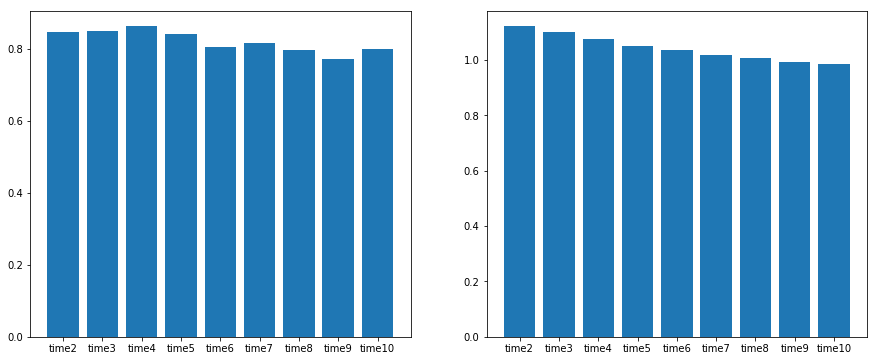

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.bar(timedff.columns, timedff.loc[train_df.target==1,:].mean().values);
plt.subplot(1,2,2)
plt.bar(timedff.columns, timedff.loc[train_df.target==0,:].mean().values);

In [139]:
full_new_feature['siteCount'] = full_df[sites].count(axis=1)

In [192]:
def checkFeatureImportance(featname,best_C = {'C': 1.6681005372000592},sparseMatrix = full_sites_sparse):
    more_normalize_feature = StandardScaler().fit_transform(full_new_feature[featname])
    X_train = hstack([full_sites_sparse.tocsr()[:idx_split,:],more_normalize_feature[:idx_split,:]]).tocsr()
    X_test = hstack([full_sites_sparse.tocsr()[idx_split:,:], more_normalize_feature[idx_split:,:]]).tocsr()
    return get_auc_roc_cv(X_train,y_train,best_C)[1],X_train,X_test 

In [151]:
score,X_train,X_test = checkFeatureImportance(['siteCount'])
score

0.9253738061210353

### Avg time per site

In [144]:
full_new_feature['minTime'] = full_df[times].min(axis=1)
full_new_feature['maxTime'] = full_df[times].max(axis=1)
full_new_feature['totalTime'] = (full_new_feature.maxTime -full_new_feature.minTime)/ np.timedelta64(1, 's')
full_new_feature['avgTimepersite'] = full_new_feature.totalTime/full_new_feature.siteCount

In [146]:
full_new_feature.loc[train_df.target==1,['avgTimepersite']].mean()

avgTimepersite    8.447491
dtype: float64

In [147]:
full_new_feature.loc[train_df.target==0,['avgTimepersite']].mean()

avgTimepersite    16.72241
dtype: float64

In [191]:
score,X_train,X_test = checkFeatureImportance(['avgTimepersite','topSite'])
score

0.9275123024526957

In [152]:
score,X_train,X_test = checkFeatureImportance(['siteCount','avgTimepersite'])
score

0.925875744998298

In [190]:
score,X_train,X_test = checkFeatureImportance(['avgTimepersite'])
score #without top sites

0.9261383391358983

In [194]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10'])
score

0.9261362480543746

In [154]:
c_values=np.logspace(-1, 2, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train,c_values)
best_score,best_C ###with start hour

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


(0.927528195547748, {'C': 2.1544346900318834})

In [155]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_13.csv') #LB  0.65202,, CV 0.927528195547748

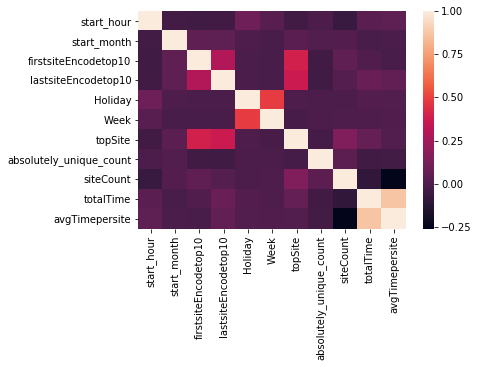

In [166]:
import seaborn as sns
sns.heatmap(full_new_feature.corr())

In [179]:
c_values=np.logspace(-1, 2, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train,c_values)
best_score,best_C ### removed top site, start hour, sitecounts (0.9260003915962765, {'C': 2.1544346900318834})

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


(0.9262106807573566, {'C': 2.1544346900318834})

In [180]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_15.csv') #LB  0.65202,, CV 0.9260003915962765

In [181]:
X_train_base.shape

(253561, 48379)

In [182]:
X_train.shape

(253561, 48380)

In [185]:
full_sites_sparse.tocsr()[:idx_split,:].shape

(253561, 48375)

In [195]:
c_values=np.logspace(-1, 2, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train)
best_score,best_C ### removed top site, start hour, sitecounts 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


(0.9261362480543747, {'C': 1.6681005372000592})

In [196]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_16.csv') #LB  0.95217, CV 0.9261362480543747

In [209]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10',"lastsiteEncodetop10",'Holiday'])
score

0.9279753580452461

In [199]:
c_values=np.logspace(-1, 2, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train)
best_score,best_C  

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


(0.9279753580452461, {'C': 1.6681005372000592})

In [210]:
c_values=np.logspace(0, 1, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train)
best_score,best_C  

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


(0.9279753580452461, {'C': 1.6681005372000592})

## Best score on LB

In [200]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_17.csv') #LB 0.95468, CV 0.9279753580452461

In [205]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10',"lastsiteEncodetop10",'Holiday','topSite'])
score

0.9293113797556722

In [202]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_18.csv') #LB 0.95422, CV 0.9293113797556722

In [207]:
c_values=np.logspace(0, 1, 10)
best_score, best_C, gridsearcher = cross_val_C_calc(X_train,y_train,c_values)
best_score,best_C  

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


(0.9293537871746613, {'C': 2.154434690031884})

In [208]:
lr = LogisticRegression(C=best_C['C'], random_state=17, solver='liblinear').fit(X_train, y_train)
y_test = lr.predict_proba(X_test)[:, 1]
write_to_submission_file(y_test, 'sumb_19.csv') #LB 0.95427, CV 0.9293537871746613

In [203]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10',"lastsiteEncodetop10",'Holiday','siteCount'])
score

0.9268674932649008

In [204]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10',"lastsiteEncodetop10",'Holiday','start_hour'])
score

0.9110652927774557

In [211]:
score,X_train,X_test = checkFeatureImportance(['absolutely_unique_count','Week','start_month', 
                                                'avgTimepersite','firstsiteEncodetop10',"lastsiteEncodetop10",'topSite'])
score

0.9274004555854376